In [9]:
using DifferentialEquations, DiffEqGPU, CUDA, ProgressLogging, Plots, SparseArrays, DifferentialEquations.EnsembleAnalysis, StaticArrays

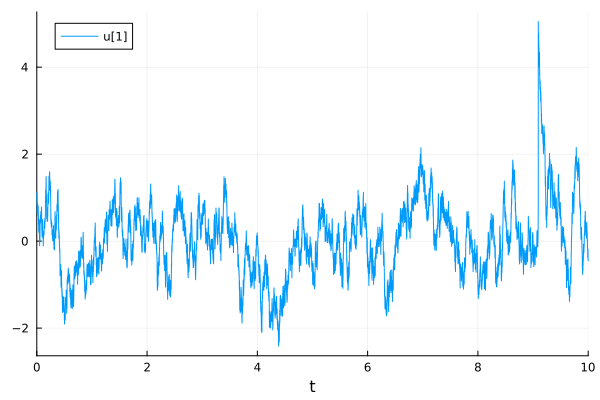

In [25]:
function ou!(du, u, p, t)
    du[1] = -10.0 * u[1]
end

function σ_ou!(du, u, p, t)
    du[1] = 3.0
end

tspan = LinRange(0.0,10.0, 30)

u0 = [1.0]

saved_values = SavedValues(eltype(tspan), Tuple{typeof(u0), typeof(u0)})
function saving_fnc(u, t, integrator)
    return (u, integrator.sol.W.u[end])
end
cb = SavingCallback(saving_fnc, saved_values; saveat=tspan)

prob_ou = SDEProblem(ou!, σ_ou!, [1.0], (0.0, 10.0))
sol = solve(prob_ou, SRA2(); progress=true, callback=cb, save_noise=true)
plot(sol, idxs=(1))

In [45]:
using DifferentialEquations, SparseArrays

function ou!(du, u, p, t)
    du[1] = -10.0 * u[1]
    du[2] = 0.0
end

function σ_ou!(du, u, p, t)
    du[1,1] = 3.0
    du[2,1] = 1.0
end

tspan = LinRange(0.0,10.0, 30)

u0 = [1.0, 0.0]
NRate = spzeros(2,2)
NRate[1,1]=1
NRate[2,1]=1

prob_ou = SDEProblem(ou!, σ_ou!, u0, (0.0, 10.0), noise_rate_prototype=NRate)
sol = solve(prob_ou, SRA3())
print(map(x->x[2], sol.u)[end-20:end])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [53]:
function lorenz!(du, u, p, t)
    du[1] = p[1] * (u[2] - u[1])
    du[2] = u[1] * (p[2] - u[3]) - u[2]
    du[3] = u[1] * u[2] - p[3] * u[3]
    du[4] = 0
end

function multiplicative_noise!(du, u, p, t)
    du[1,1] = 4.0 #* u[1]
    du[2,2] = 0.1 #* u[2]
    du[3,3] = 3.0 #* u[3]
    du[4,1] = 1.0
end

tspan = LinRange(0.0,10.0, 30)

u0 = Float32[1.0,0.0,0.0,0.0]
p = Float32[10.0f0,28.0f0,8/3f0]

NRate = spzeros(4,4)
NRate[1,1]=1
NRate[2,2]=1
NRate[3,3]=1
NRate[4,1]=1

prob_l = SDEProblem(lorenz!, multiplicative_noise!, u0, (0.0, 10.0), p, noise_rate_prototype = NRate)

SDEProblem with uType Vector{Float32} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float32}:
 1.0
 0.0
 0.0
 0.0

In [24]:
prob_l.f

(::SDEFunction{true, SciMLBase.FullSpecialize, typeof(lorenz!), typeof(multiplicative_noise!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) (generic function with 1 method)

In [2]:
function lorenz!(du, u, p, t)
    du[1] = p[1] * (u[2] - u[1])
    du[2] = u[1] * (p[2] - u[3]) - u[2]
    du[3] = u[1] * u[2] - p[3] * u[3]
    du[4] = 0
end

function multiplicative_noise!(du, u, p, t)
    du[1] = 4.0 #* u[1]
    du[2] = 0.1 #* u[2]
    du[3] = 3.0 #* u[3]
    du[4] = 1.0
end

Γ = [1. 0. 0. 1.; 0. 1. 0. 0.; 0. 0. 1. 0.; 1. 0. 0. 1.]
tspan = (0.0, 10.0)
cus_noise = CorrelatedWienerProcess!(Γ, tspan[1], zeros(4), zeros(4))

u0 = Float32[1.0,0.0,0.0,0.0]
p = Float32[10.0f0,28.0f0,8/3f0]

prob_l = SDEProblem(lorenz!, multiplicative_noise!, u0, tspan, p, noise = cus_noise)

SDEProblem with uType Vector{Float32} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float32}:
 1.0
 0.0
 0.0
 0.0

In [4]:
sol = solve(prob_l; progress=true, save_noise=true, saveat=0.01, dt=0.01)
plot(sol, idxs=(1,2,3))

ErrorException: Bridging distribution is unknown. Cannot use adapativity

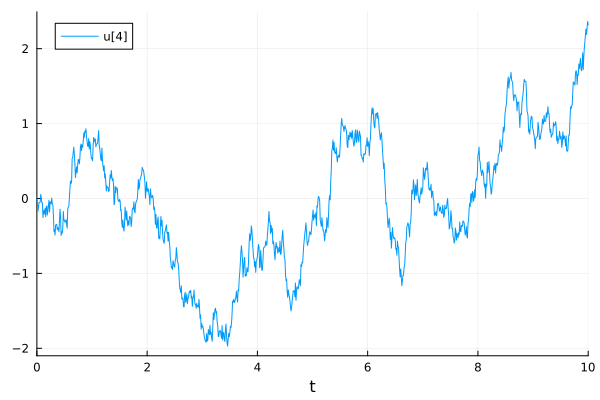

In [42]:
plot(sol, idxs=(4))

In [20]:
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, EnsembleCPUArray(), trajectories = 100)

EnsembleSolution Solution of length 100 with uType:
RODESolution{Float32, 2, Vector{Vector{Float32}}, Nothing, Nothing, Vector{Float32}, NoiseProcess{Float64, 2, Float32, SparseVector{Float64, Int64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), Nothing, true, ResettableStacks.ResettableStack{Tuple{Float32, SparseVector{Float64, Int64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float32, SparseVector{Float64, Int64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float32}, Tuple{Float32, Float32}, true, Tuple{Float32, Float32, Float32}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(lorenz), typeof(multiplicative_noise), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(multiplicati

In [ ]:
zeros(4,4)

In [107]:
print(typeof(NRate))

Matrix{Float64}

In [26]:
ISW = map(x->x[4], sol.u)

1001-element Vector{Float32}:
  0.0
  0.047137212
  0.08206185
  0.13621363
  0.063469015
  0.059535764
  0.048441295
  0.12086773
  0.12713808
 -0.06610506
  ⋮
 -0.87788856
 -0.843057
 -0.85472184
 -0.7233152
 -0.62111044
 -0.6415014
 -0.61352587
 -0.6185703
 -0.8135021

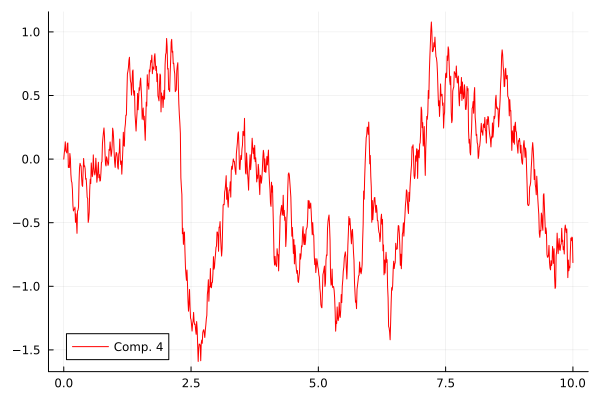

In [29]:
plot(sol.W.t, map(x->x[4], sol.W.u), label="Noise", color=:blue)
plot(sol.t, ISW, label="Comp. 4", color=:red)

In [4]:
function lorenz(du, u, p, t)
    du[1] = p[1] * (u[2] - u[1])
    du[2] = u[1] * (p[2] - u[3]) - u[2]
    du[3] = u[1] * u[2] - p[3] * u[3]
end

u0 = Float32[1.0;0.0;0.0]
tspan = (0.0f0,100.0f0)
p = [10.0f0,28.0f0,8/3f0]
prob = ODEProblem(lorenz,u0,tspan,p)
prob_func = (prob,i,repeat) -> remake(prob,p=rand(Float32,3).*p)
monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy=false)
sol = solve(monteprob,Tsit5(),EnsembleGPUArray(CUDA.device()),trajectories=10_000,saveat=1.0f0);

In [6]:
function lorenz(du, u, p, t)
    du[1] = p[1] * (u[2] - u[1])
    du[2] = u[1] * (p[2] - u[3]) - u[2]
    du[3] = u[1] * u[2] - p[3] * u[3]
end

u0 = Float32[1.0;0.0;0.0]
tspan = (0.0f0,100.0f0)
p = [10.0f0,28.0f0,8/3f0]
prob = ODEProblem(lorenz,u0,tspan,p)

prob_func = (prob,i,repeat) -> begin
    return remake(prob,p=rand(Float32,3).*p)
end

monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy=false)
sol = solve(monteprob,Tsit5(),EnsembleCPUArray(),trajectories=10_000,saveat=1.0f0);

In [40]:
using JLD2
jldsave("TestSave.jld2"; sol)

In [6]:
const pre_p = [rand(Float32, 3) for i in 1:10_000]

10000-element Vector{Vector{Float32}}:
 [0.682254, 0.8148129, 0.9254294]
 [0.3576401, 0.62615323, 0.4449969]
 [0.059657216, 0.58654255, 0.08850402]
 [0.99990857, 0.8716293, 0.7132983]
 [0.03188181, 0.06091839, 0.09340364]
 [0.13295257, 0.4803375, 0.6837046]
 [0.44706285, 0.29684561, 0.8156824]
 [0.04382187, 0.79160285, 0.7802653]
 [0.10368669, 0.85934645, 0.3500312]
 [0.619489, 0.23903054, 0.734328]
 ⋮
 [0.74057305, 0.33234757, 0.9726603]
 [0.3069312, 0.6511777, 0.9815975]
 [0.82552254, 0.42567843, 0.77763814]
 [0.5750405, 0.87736076, 0.05278033]
 [0.79880536, 0.9992081, 0.82627076]
 [0.6770217, 0.09572077, 0.15880316]
 [0.49270827, 0.31542993, 0.19159353]
 [0.6821491, 0.7186109, 0.6461705]
 [0.375616, 0.5644695, 0.32804042]

In [27]:
function lorenz(du, u, p, t)
    du[1] = p[1] * (u[2] - u[1])
    du[2] = u[1] * (p[2] - u[3]) - u[2]
    du[3] = u[1] * u[2] - p[3] * u[3]
    du[4] = 0
end

function multiplicative_noise(du, u, p, t)
    # println(du)
    du[1,1] = 0.1 #* u[1]
    du[2,2] = 0.4
    du[4,1] = 1.0
end

NRate = spzeros(4,2)
NRate[1,1] = 1
NRate[4,1] = 1
NRate[2,2] = 1

CUDA.allowscalar(false)
u0 = ComplexF32[1.0; 0.0; 0.0; 0.0]
tspan = (0.0f0, 10.0f0)
p = (10.0f0, 28.0f0, 8 / 3.0f0)
prob = SDEProblem(lorenz, multiplicative_noise, u0, tspan, p, noise_rate_prototype = NRate)

prob_func = (prob, i, repeat) -> remake(prob, p = pre_p[i] .* p)
monteprob = EnsembleProblem(prob, prob_func = prob_func)
# EnsembleGPUArray(CUDA.CUDABackend())
# EnsembleCPUArray()
sol = solve(monteprob, SRA1(), EnsembleCPUArray(), trajectories = 10_000, saveat = 1.0f0)

BoundsError: BoundsError: attempt to access 4-element view(::Matrix{ComplexF32}, :, 1) with eltype ComplexF32 at index [2, 2]

In [11]:
function lorenz(u, p, t)
    du1 = p[1] * (u[2] - u[1])
    du2 = u[1] * (p[2] - u[3]) - u[2]
    du3 = u[1] * u[2] - p[3] * u[3]
    du4 = 0
    return SVector{4}(du1, du2, du3, du4)
end

function multiplicative_noise(u, p, t)
    # println(du)
    du11 = 0.1 #* u[1]
    du22 = 0.4
    du41 = 1.0
    return @SMatrix[du11    0.;
                    0.  du22;
                    0.  0.;
                    0.  0.;
                    du41    0.]
end

NRate = spzeros(4,2)
NRate[1,1] = 1
NRate[4,1] = 1
NRate[2,2] = 1

CUDA.allowscalar(false)
u0 = @SVector ComplexF32[1.0; 0.0; 0.0; 0.0]
tspan = (0.0f0, 10.0f0)
p = @SVector [10.0f0, 28.0f0, 8 / 3.0f0]
prob = SDEProblem(lorenz, multiplicative_noise, u0, tspan, p, noise_rate_prototype = NRate)

prob_func = (prob, i, repeat) -> remake(prob, p = (@SVector rand(Float32, 3)) .* p)
monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy=false)
# EnsembleGPUArray(CUDA.CUDABackend())
# EnsembleCPUArray()
sol = solve(monteprob, SRA2(), EnsembleCPUArray(), trajectories = 10_000, saveat = 1.0f0)

UndefVarError: UndefVarError: `du` not defined

In [8]:
sol[1]

retcode: DtLessThanMin
Interpolation: 1st order linear
t: 4-element Vector{Float32}:
 0.0
 1.0
 2.0
 3.0
u: 4-element Vector{SubArray{ComplexF32, 1, Matrix{ComplexF32}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}:
 [1.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im]
 [-1.9432452f0 - 0.18650962f0im, -4.0763845f0 - 0.21468328f0im, 10.397136f0 - 0.3279399f0im, -0.0f0 + 0.0f0im]
 [-3.9320195f0 - 0.22178648f0im, -6.5472994f0 - 0.4739896f0im, 10.150896f0 - 0.03951665f0im, 0.0f0 + 0.0f0im]
 [-6.9988723f0 - 0.34284616f0im, -11.305175f0 - 0.45715854f0im, 13.768399f0 + 0.5584977f0im, 0.0f0 + 0.0f0im]

In [28]:
sol = solve(prob, SRA1(), saveat = 1.0f0)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float32}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
u: 11-element Vector{Vector{ComplexF32}}:
 [1.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im]
 [-9.289892f0 + 0.0f0im, -8.77746f0 + 0.0f0im, 28.564587f0 + 0.0f0im, -1.2813098f0 + 0.0f0im]
 [-8.182597f0 + 0.0f0im, -9.1411295f0 + 0.0f0im, 25.353155f0 + 0.0f0im, -1.0138544f0 + 0.0f0im]
 [-8.149969f0 + 0.0f0im, -7.4921637f0 + 0.0f0im, 27.489515f0 + 0.0f0im, -2.1580567f0 + 0.0f0im]
 [-9.273416f0 + 0.0f0im, -9.759827f0 + 0.0f0im, 27.223864f0 + 0.0f0im, -1.7727622f0 + 0.0f0im]
 [-7.354276f0 + 0.0f0im, -7.503919f0 + 0.0f0im, 25.429623f0 + 0.0f0im, -3.279227f0 + 0.0f0im]
 [-9.427941f0 + 0.0f0im, -8.5337305f0 + 0.0f0im, 29.334362f0 + 0.0f0im, -3.2045481f0 + 0.0f0im]
 [-8.5074005f0 + 0.0f0im, -9.858392f0 + 0.0f0im, 25.198f0 + 0.0f0im, -4.7106986f0 + 0.0f0im]
 [-7.4225097f0 + 0.0f0im, -6.343712f0 + 0.0f0im, 27.209272f0 + 0.0f0im, -4.455

In [21]:
sol[2]

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float32}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
u: 11-element Vector{Vector{ComplexF32}}:
 [1.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im]
 [-0.28295484f0 + 0.0f0im, -9.542521f0 + 0.0f0im, 18.345928f0 + 0.0f0im, -0.11310902f0 + 0.0f0im]
 [-2.219047f0 + 0.0f0im, -2.4099987f0 + 0.0f0im, 13.062403f0 + 0.0f0im, -1.0781826f0 + 0.0f0im]
 [-4.0508447f0 + 0.0f0im, 1.4735785f0 + 0.0f0im, 19.624578f0 + 0.0f0im, -1.1379251f0 + 0.0f0im]
 [0.86048824f0 + 0.0f0im, 1.8337873f0 + 0.0f0im, 5.608461f0 + 0.0f0im, -1.2350605f0 + 0.0f0im]
 [0.5805781f0 + 0.0f0im, -6.1759477f0 + 0.0f0im, 17.664383f0 + 0.0f0im, 0.9220784f0 + 0.0f0im]
 [-4.270918f0 + 0.0f0im, -1.4016488f0 + 0.0f0im, 18.612518f0 + 0.0f0im, -0.6287626f0 + 0.0f0im]
 [-6.0947814f0 + 0.0f0im, -9.416118f0 + 0.0f0im, 15.603251f0 + 0.0f0im, 0.5386241f0 + 0.0f0im]
 [1.0517334f0 + 0.0f0im, 2.104732f0 + 0.0f0im, 9.345927f0 + 0.0f0im, 1.